In [1]:
from pathlib import Path
from fastai.vision.all import *

Train the model using resnet

In [2]:
dls = ImageDataLoaders.from_folder(
    Path('../data/processed'), 
    train='train', 
    valid_pct=0.2,
    size=224,
    bs=4,
    shuffle_train=True,
    # item_tfms=Resize(256, method=ResizeMethod.Squish)
)

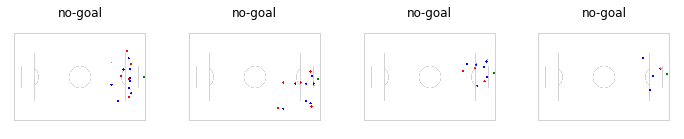

In [3]:
dls.show_batch(nrows=1, ncols=4)

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,accuracy,time


Review the model

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Make some predictions on the test-data.

First, let's go through predicting a single image...

In [ ]:
import PIL

# Load an image from the test data
example_img = PILImage.create('../data/processed/test/goal/07d8857c-00fc-4f4d-b1ae-86b1ed377133.png')

display(example_img.to_thumb(256, 256))

In [ ]:
_, _, probs = learn.predict(example_img)

xg, _ = probs

print(f'xG: {float(xg)}')

Load all test data

In [ ]:
import json


def get_event_id(filepath):
    return filepath.stem


def is_goal(filepath):
    return filepath.parent.name == 'goal'


def predict_xg(filepath):
    img = PILImage.create(filepath)
    _, _, probs = learn.predict(img)
    xg, _ = probs
    return float(xg)


def get_statsbomb_xg(filepath):
    event_id = get_event_id(filepath)
    with open(f'../data/raw/{event_id}.json', 'r') as f:
        e = json.load(f)
    return e['shot']['statsbomb_xg']

In [ ]:
def process_test_shot(filepath):
    return {
        'path': filepath,
        'id': get_event_id(filepath),
        'is_goal': is_goal(filepath),
        'xg': predict_xg(filepath),
        'sb_xg': get_statsbomb_xg(filepath)
    }


test_shots = Path('../data/processed/test/goal/').ls() + Path('../data/processed/test/no-goal/').ls()
shots_predicted = [process_test_shot(s) for s in (test_shots[0:10] + test_shots[-10:])]

In [ ]:
import pandas as pd

predictions = pd.DataFrame(shots_predicted)

# Add inferred columns
predictions['diff'] = abs(predictions['sb_xg'] - predictions['xg'])

predictions

Compare to SB xG

In [ ]:
for _, p in predictions.head(10).iterrows():
    img = PILImage.create(p['path']).to_thumb(512, 512)
    print(f'Im-xG: {p["xg"]:.2f}')
    print(f'SB-xG: {p["sb_xg"]:.2f}')
    print(f'Diff:  {p["diff"]:.2f}')
    display(img)

In [ ]:
# Compare overall error rate between SB and image xG

In [ ]:
# Show the most different N predictions (top & bottom)